In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('dark_background')

In [54]:
###################### FUNCTIONS TO GENERATE IMAGES, please ignore ####################
import numpy as np

def make_data(N=30, err=0.8, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y
        
def bias_variance_tradeoff() -> None:
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import make_pipeline
    
    def PolynomialRegression(degree=2, **kwargs):
        return make_pipeline(PolynomialFeatures(degree),
                             LinearRegression(**kwargs))
    
    X, y = make_data()
    xfit = np.linspace(-0.1, 1.0, 1000)[:, None]
    model1 = PolynomialRegression(1).fit(X, y)
    model20 = PolynomialRegression(20).fit(X, y)
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
    
    ax[0].scatter(X.ravel(), y, s=40)
    ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
    ax[0].axis([-0.1, 1.0, -2, 14])
    ax[0].set_title('High-bias model: Underfits the data', size=14)
    
    ax[1].scatter(X.ravel(), y, s=40)
    ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
    ax[1].axis([-0.1, 1.0, -2, 14])
    ax[1].set_title('High-variance model: Overfits the data', size=14)
    
    fig.savefig('images/05.03-bias-variance.png')
    return

def bias_variance_tradeoff_metrics() -> None:
    X, y = make_data()

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
    
    X2, y2 = make_data(10, rseed=42)
    
    ax[0].scatter(X.ravel(), y, s=40, c='blue')
    ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
    ax[0].axis([-0.1, 1.0, -2, 14])
    ax[0].set_title('High-bias model: Underfits the data', size=14)
    ax[0].scatter(X2.ravel(), y2, s=40, c='red')
    ax[0].text(0.02, 0.98, "training score: $R^2$ = {0:.2f}".format(model1.score(X, y)),
               ha='left', va='top', transform=ax[0].transAxes, size=14, color='blue')
    ax[0].text(0.02, 0.91, "validation score: $R^2$ = {0:.2f}".format(model1.score(X2, y2)),
               ha='left', va='top', transform=ax[0].transAxes, size=14, color='red')
    
    ax[1].scatter(X.ravel(), y, s=40, c='blue')
    ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
    ax[1].axis([-0.1, 1.0, -2, 14])
    ax[1].set_title('High-variance model: Overfits the data', size=14)
    ax[1].scatter(X2.ravel(), y2, s=40, c='red')
    ax[1].text(0.02, 0.98, "training score: $R^2$ = {0:.2g}".format(model20.score(X, y)),
               ha='left', va='top', transform=ax[1].transAxes, size=14, color='blue')
    ax[1].text(0.02, 0.91, "validation score: $R^2$ = {0:.2g}".format(model20.score(X2, y2)),
               ha='left', va='top', transform=ax[1].transAxes, size=14, color='red')
    
    fig.savefig('images/05.03-bias-variance-2.png')
    return

def validation_curve() -> None:
    x = np.linspace(0, 1, 1000)
    y1 = -(x - 0.5) ** 2
    y2 = y1 - 0.33 + np.exp(x - 1)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(x, y2, lw=10, alpha=0.5, color='blue')
    ax.plot(x, y1, lw=10, alpha=0.5, color='red')
    
    ax.text(0.15, 0.05, "training score", rotation=45, size=16, color='blue')
    ax.text(0.2, -0.05, "validation score", rotation=20, size=16, color='red')
    
    ax.text(0.02, 0.1, r'$\longleftarrow$ High Bias', size=18, rotation=90, va='center')
    ax.text(0.98, 0.1, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
    ax.text(0.48, -0.12, 'Best$\\longrightarrow$\nModel', size=18, rotation=90, va='center')
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.3, 0.5)
    
    ax.set_xlabel(r'model complexity $\longrightarrow$', size=14)
    ax.set_ylabel(r'model score $\longrightarrow$', size=14)
    
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    
    ax.set_title("Validation Curve Schematic", size=16)
    
    fig.savefig('images/05.03-validation-curve.png')
    return

In [38]:
# THINKING ABOUT MODEL VALIDATION
# In principle, model validation is very simple: after choosing a model and
# its hyper-parameters, we can estimate how effective it is by applying it
# to some of the training data and comparing the prediction to the known 
# value. The following code shows a naive approach to model validation and
# why it fails, before exploring the use of holdout sets and cross-validation
# for more robust model evaluation.
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [39]:
# Now we choose a model and hyperparameters. Here, we'll use a k-neighbors 
# classifier with n_neighbors = 1. This is a very simple and intuitive model
# that says "the label of an unknown point is the same as the label of its
# closest training point".
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors = 1)

In [40]:
# Then we train the model, and use it to predict labels for data we already
# know.
model.fit(X, y)
y_model = model.predict(X)

In [41]:
# Finally, we compute the fraction of correctly labeled points
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

In [42]:
# We can see an accuracy score of 1.0, which indicates that 100% of points
# were correctly labeled by our model! BUT here we are testing the model on 
# the same data we trained it with, so if we had an accuracy < 1.0 it would
# be a problem :D. Furthermore, the nearest neighbor model is an 
# instance-based estimator that simply stores the training data, and
# predicts labels by comparing new data to these stored points.

In [43]:
# MODEL VALIDATION IN THE RIGHT WAY: HOLDOUT SETS
# We can get a better sense of a model's performance using what's known as
# a holdout set; that is, we hold back some subset of the data from the
# training of the model, and then use this holdout set to check the 
# model performance. We can do this splitting using the train_test_split 
# utility in scikit-learn.
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state = 0,
                                  train_size = .5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

# We see here a more reasonable result: the nearest-neighbor classifier is
# about 90% accurate on this holdout set. The holdout set is similar to
# unknown data, because the model has not seen it before.

0.9066666666666666

In [44]:
# MODEL VALIDATION VIA CROSS-VALIDATION
# One disadvantage of using a holdout set for model validation is that we
# have lost a portion of our data to the model training. In the previous case,
# half of the dataset does not contribute to the training of the model! This
# is not optimal, and can cause problems, expecially if the initial set of 
# training data is small. One way to address this is to use cross-validation--
# that is, to do a sequence of fits where each subset of the data is used
# both as a training set and as a validation set--
# Here we do two validation trials, alternately using each half of the data
# as a holdout set.
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)
# What comes out are two accuracy scores, which we could combine (by, say,
# taking the mean) to get a better measure of the global model performance. 
# This particular form of cross-validation is a "two-fold cross-validataion",
# one in which we have split the data into two sets and used each in turn as
# a validation set.

(0.96, 0.9066666666666666)

In [45]:
# We could expand on this idea to use even more trials, and more folds in
# the data. Here we split the data into five groups, and use each of them
# in turn to evaluate the model fit on the other 4/5 of the data. This would
# be rather tedious to do by hand, and so we can use scikit-learn's
# cross_val_score convenience routine to do it succinctly.
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv = 5)
# Repeating the validation across different subsets of the data gives us an
# even better idea of the performance of the algorithm.

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

In [46]:
# Scikit-learn implements a number of cross-validation schemes that are 
# useful in particular situations; these are implemented via iterators in
# the model_selection module. For example, we might wish to go to the 
# extreme case in which our number of folds is equal to the number of data
# points; that is, we train on all points but one in each trial. This type
# of cross-validation is known as "leave-one-out" cross-validation, and can
# be used as follows.
from sklearn.model_selection import LeaveOneOut
# NOTE: as of 4/24/24, LeaveOneOut() takes NO arguments...
scores = cross_val_score(model, X, y, cv = LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [47]:
# Because we have 150 samples, the leave-one-out cross-validation scores for
# 150 trials, and the score indicates either successful (1) or unsuccessful 
# (0) prediction. Taking the mean of these gives an estimate of the error
# rate!
scores.mean()

0.96

In [48]:
# SELECTING THE BEST MODEL
# Now that we've seen the basics of validation and cross-validation, we will
# go into a little more depth regarding model selection and selection of
# hyperparameters. 

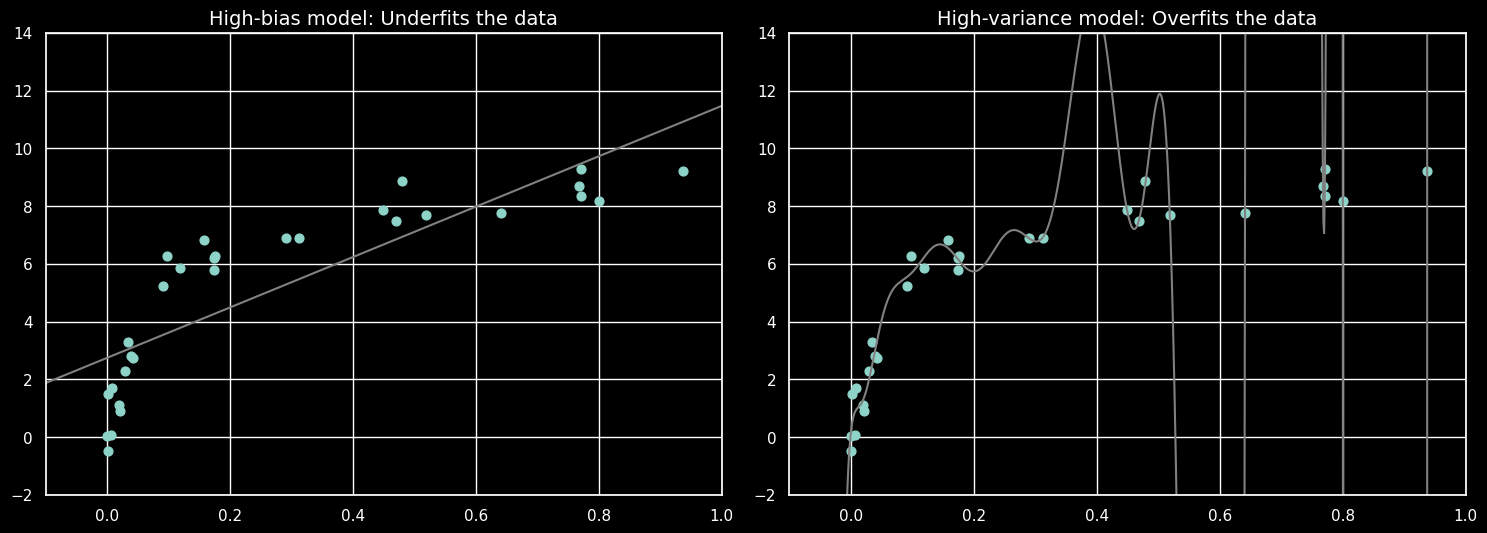

In [49]:
# THE BIAS-VARIANCE TRADE-OFF
# Fundamentally, the question of "the best model" is about finding a sweet
# spot in the trade-off between bias and variance. High bias model: underfits
# the data, high-variance model: overfits the data. It is clear that neither 
# of these approaches is a particularly good one, but they fail in different 
# ways.
bias_variance_tradeoff()

In [50]:
# The model on the left attempts to find a straight-line fit through the data.
# Because the data are intrinsically more complicated than a straight line, 
# the straight line model will never be able to describe this dataset well.
# Such a model is said to "underfit" the data; that is, it does not have
# enough model flexibility to suitably account for all the features in the 
# data. Another way of saying this is that the model has high "bias". The
# model on the right attemps to fit a high-order polynomial through the data. 
# Here, the model fit has enough flexibility to nearly perfectly account for 
# the fine features in the data, but even though it very accurately describes 
# the training data, its precise form seems to be more reflective of the
# particular noise properties of the data rather than the intrisic properties 
# of whatever process generated that data. Such a model is said to "overfit"
# the data; that is, it has so much model flexibility that the model ends up
# accounting for random errors as well as the underlying data distribution. 
# Another way of saying this is that the model has high "variance".

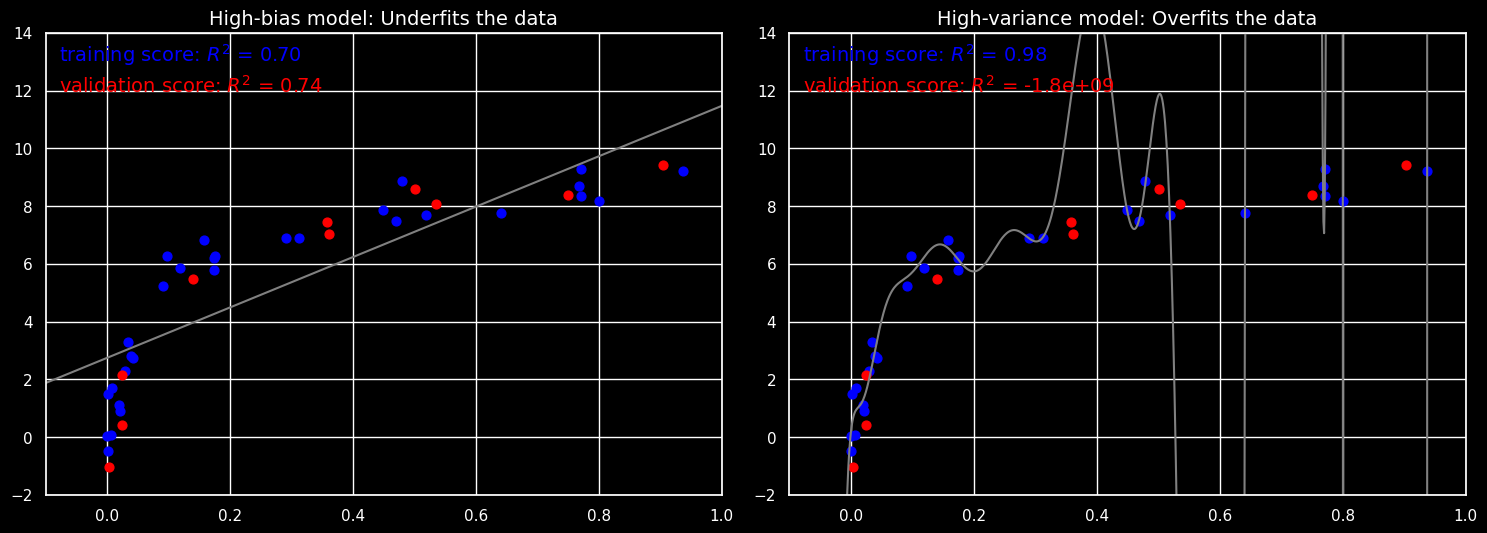

In [55]:
# To look at this in another light, consider what happens if we use these two
# models to predict the y-value for some new data. In the following graphs,
# the red points indicate data that is omitted from the training set.
bias_variance_tradeoff_metrics()

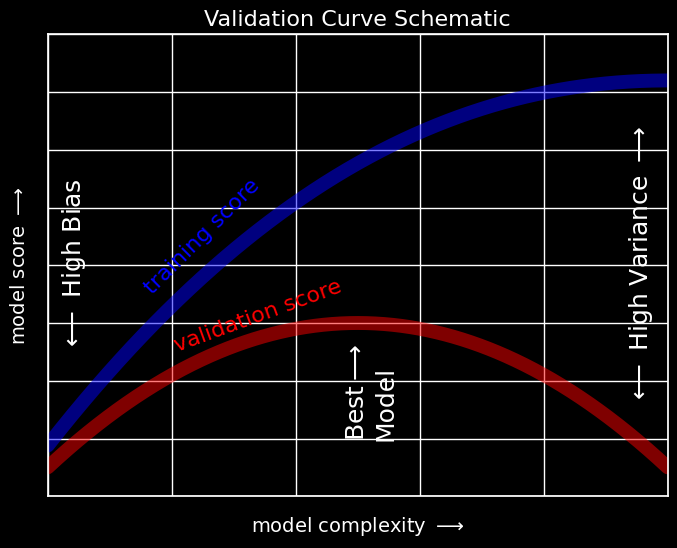

In [56]:
# The score here is the R^2 score, or coefficient of determination, which 
# measures how well a model performs relative to a simple mean of the target 
# values. R^2 = 2 indicates a perfect match, R^2 = 0 indicates the model does
# no better than simply taking the mean of the data, and negative values mean
# even worse models. For high-bias models, the performance of the model on 
# the validation set is similar to the performance on the trainig set. For
# high-variance models, the performance of the model on the validation set is
# far worse than the performance on the training set. If we imagine that we 
# have some ability to tune the model complexity, we would expect the
# training score and validation score to behave as follows. The diagram shown
# is often called a validation curve, and we can see its essential features:
# -The training score is everywhere higher than the validation score, i.e.
# the model will be a better fit to data it has seen than to data it has not
# seen. 
# -For very low model complexity (high bias), the training data is underfit,
# which means that the model is a poor predictor both for the training data 
# and previously unseen data.
# -For very high model complexity (high variance), the training data is
# overfit, which means that the model predicts the training data very well,
# but fails for any previously unseen data. 
# -For some intermediate value, the validation curve has a maximum.
# This level of complexity indicates a suitable trade-off between bias and
# variance.
validation_curve()